#### Importing Necessary libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.regularizers import l1, l2


from sklearn.preprocessing import MinMaxScaler

#### Creating a pandas dataframe

In [ ]:
df=pd.read_csv("/content/TATASTEEL.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-21,60.298702,60.846523,58.983925,59.217346,23.269278,43827924
1,2017-08-22,60.017643,60.017643,58.536140,59.031563,23.196274,38737966
2,2017-08-23,59.450768,60.636925,58.736214,60.460667,23.757839,41132489
3,2017-08-24,60.594051,61.027546,60.079571,60.879871,23.922562,51528531
4,2017-08-28,60.989437,61.251438,60.193901,60.579758,23.804634,37426701


#### Formating the date while analysing and plotting Close prices

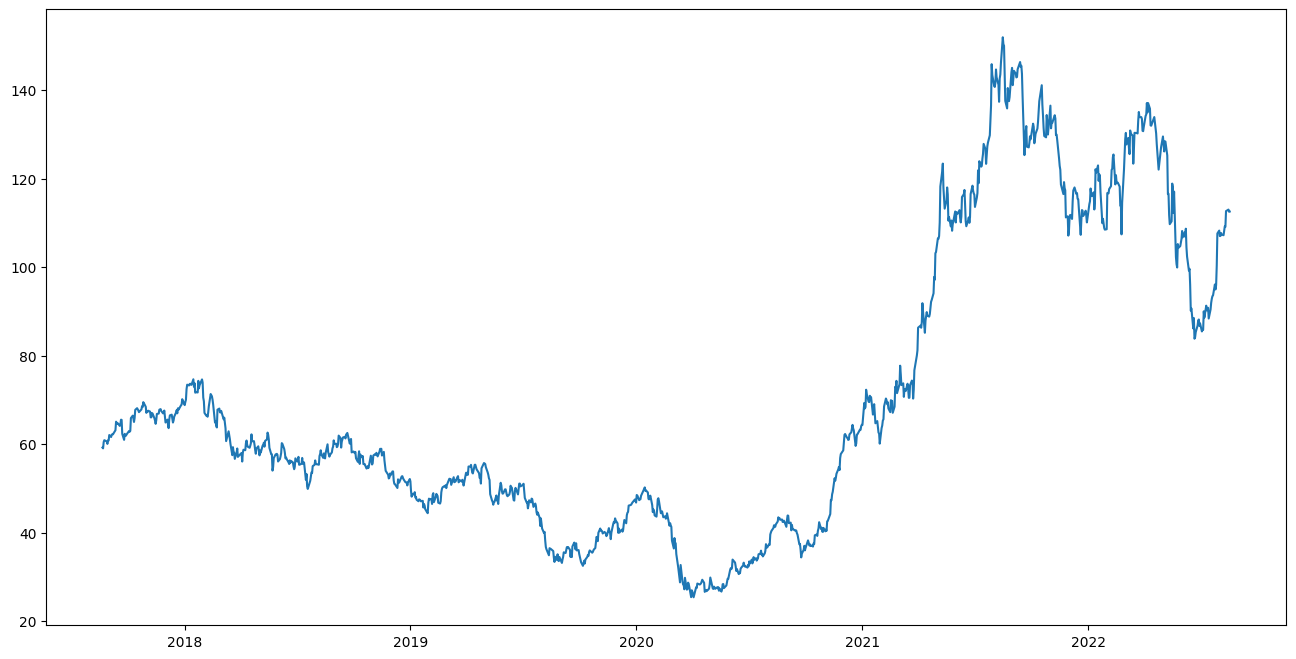

In [ ]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

#### We shall sort our data in an ascending order column wise on date and then filter the dates and close columns

In [ ]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(data)),columns=['Date','Close'])

for i in range(0,len(data)):
  new_dataset["Date"][i] = data["Date"][i]
  new_dataset["Close"][i] = data["Close"][i]

date_column = data["Date"]
print(date_column)
print(new_dataset)

Date
2017-08-21   2017-08-21
2017-08-22   2017-08-22
2017-08-23   2017-08-23
2017-08-24   2017-08-24
2017-08-28   2017-08-28
                ...    
2022-08-11   2022-08-11
2022-08-12   2022-08-12
2022-08-16   2022-08-16
2022-08-17   2022-08-17
2022-08-18   2022-08-18
Name: Date, Length: 1235, dtype: datetime64[ns]
                     Date       Close
0     2017-08-21 00:00:00   59.217346
1     2017-08-22 00:00:00   59.031563
2     2017-08-23 00:00:00   60.460667
3     2017-08-24 00:00:00   60.879871
4     2017-08-28 00:00:00   60.579758
...                   ...         ...
1230  2022-08-11 00:00:00  109.099998
1231  2022-08-12 00:00:00  112.650002
1232  2022-08-16 00:00:00       113.0
1233  2022-08-17 00:00:00       112.5
1234  2022-08-18 00:00:00  112.550003

[1235 rows x 2 columns]


#### Normalising our data using MinMaxScaler and dividing the data into training and validation dataset

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis=1, inplace=True)

#scaling the data
scaled_data = scaler.fit_transform(new_dataset)

#Splitting our data into training and validation sets
train_data = scaled_data[:987, :]
valid_data = scaled_data[987:, :]
sequence_length = 60
x_train_data, y_train_data = [], []
x_val,y_val = [],[]

for i in range(sequence_length, len(train_data)):
    x_train_data.append(train_data[i - sequence_length:i, 0])
    y_train_data.append(train_data[i, 0])

for i in range(sequence_length, len(valid_data)):
    x_val.append(valid_data[i - sequence_length:i, 0])
    y_val.append(valid_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_val, y_val = np.array(x_val), np.array(y_val)
# Reshape the data for input to the LSTM
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))


#### Creating the actual LSTM Model

In [ ]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=25,return_sequences=True,recurrent_regularizer=l2(0.01),input_shape=(x_train_data.shape[1],1))) #adding l1 and l2
lstm_model.add(LSTM(units=25,recurrent_regularizer=l2(0.01)))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

lstm_model.save("saved_model.h5")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Here, we can define the callback early stopping so that we stop our model if the validation loss does not improve by a certain value for consecutive epochs

In [ ]:
# ModelCheckpoint callback is used to save only the best model out of all the epochs
checkpoint = ModelCheckpoint(filepath='/content/saved_model.h5', verbose=2, save_best_only=True)

# EarlyStopping callback is used to stop the training when accuracy doesn't improve. In this case patience is set to 5, so that when the model accuracy doesn't improve for more that 5 epochs earlystopping kicks in
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

callbacks = [checkpoint, early_stop]

Fitting the model...

In [ ]:
history1 = lstm_model.fit(x_train_data,
          y_train_data,
          epochs=50,
          batch_size = 32,
          callbacks=callbacks,
          verbose=2,
          validation_data=(x_val, y_val))

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.35181, saving model to /content/saved_model.h5
29/29 - 7s - loss: 0.4375 - val_loss: 0.3518 - 7s/epoch - 231ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.35181 to 0.21068, saving model to /content/saved_model.h5
29/29 - 1s - loss: 0.2652 - val_loss: 0.2107 - 1s/epoch - 50ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.21068 to 0.13668, saving model to /content/saved_model.h5
29/29 - 1s - loss: 0.1678 - val_loss: 0.1367 - 1s/epoch - 48ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.13668 to 0.08963, saving model to /content/saved_model.h5
29/29 - 1s - loss: 0.1074 - val_loss: 0.0896 - 1s/epoch - 49ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.08963 to 0.05753, saving model to /content/saved_model.h5
29/29 - 1s - loss: 0.0691 - val_loss: 0.0575 - 1s/epoch - 48ms/step
Epoch 6/50

Epoch 6: val_loss improved from 0.05753 to 0.03945, saving model to /content/saved_model.h5
29/29 - 1s - loss: 0.0446 - val_loss: 0

#### Taking a sample from the data to check for the accuracy of predicted values

In [ ]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 [==============================] - 1s 12ms/step


#### Plotting actual values and predicted values

<ipython-input-45-397e778e3e61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


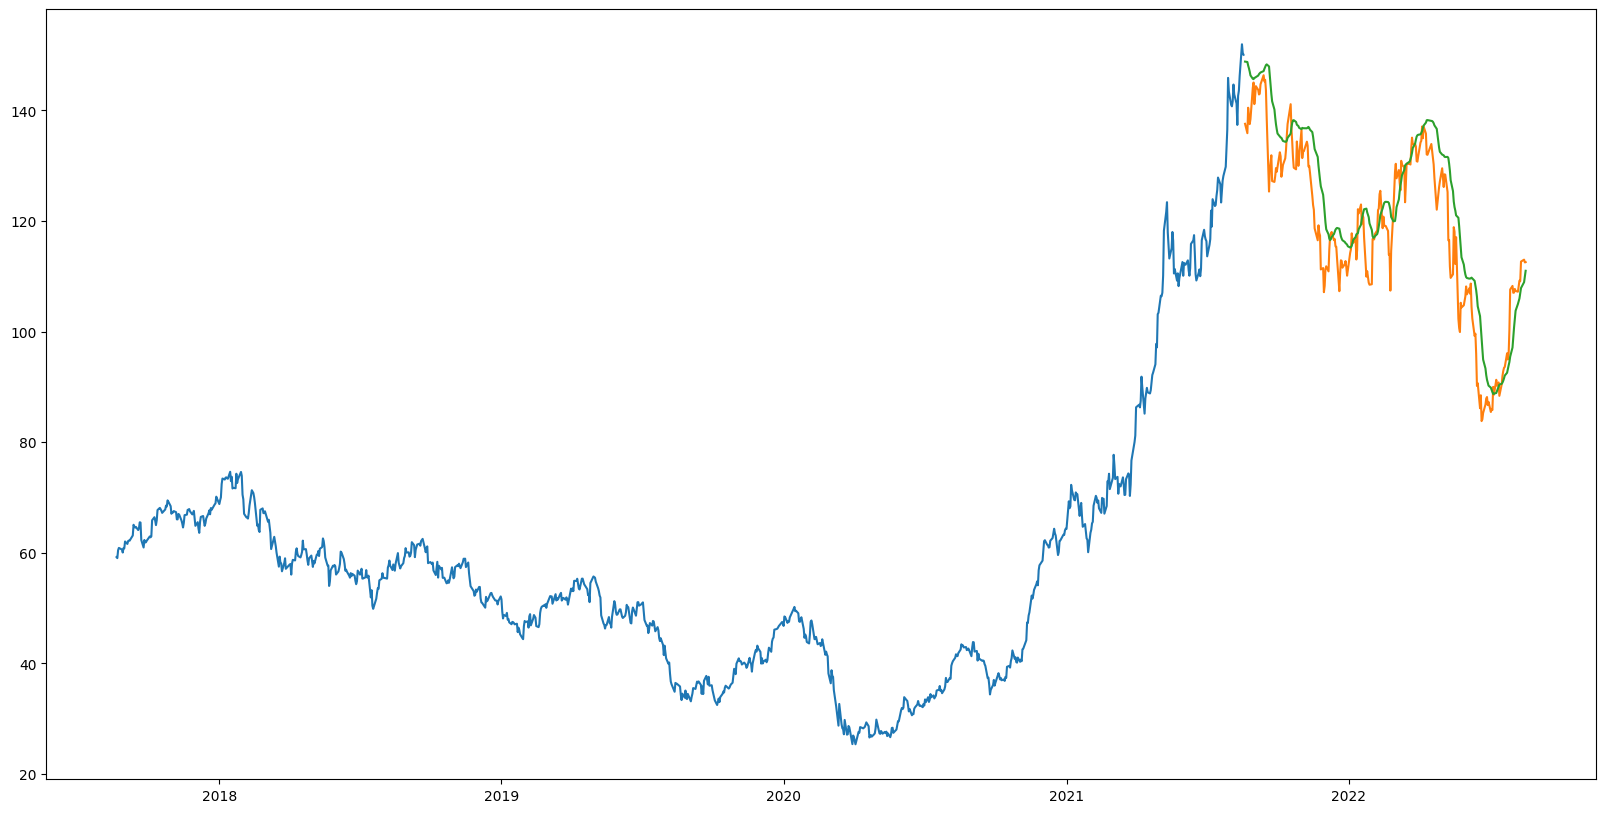

In [ ]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

Here we can see that the predicted values (represented in green) closely follow the actual values (represented by orange)

#### Checking if our model is overfit or not

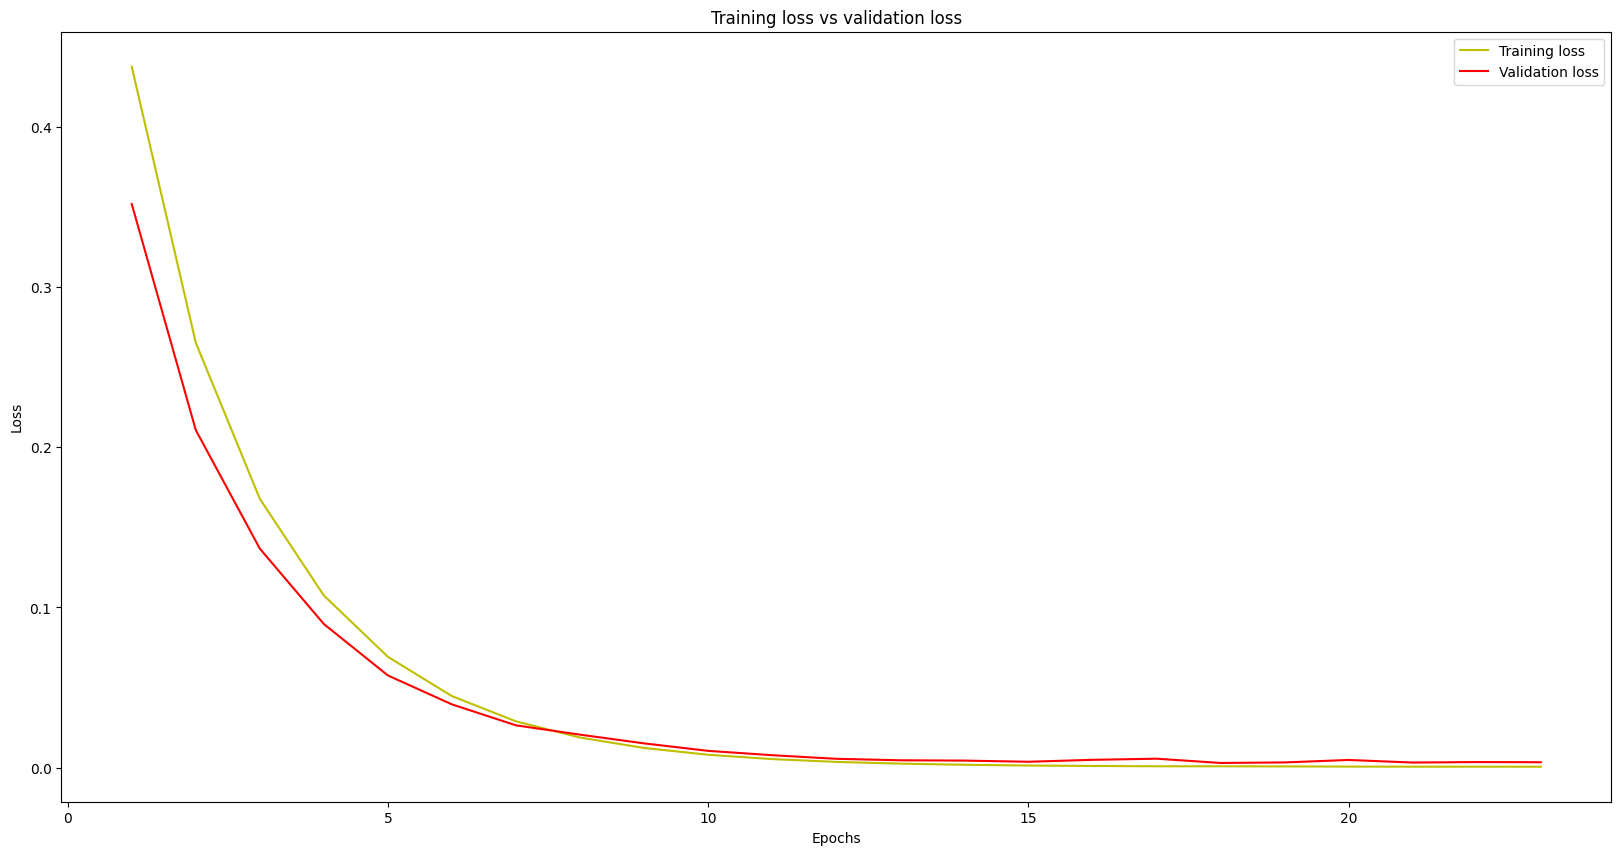

In [ ]:
# plotting train and val accuracy in each epoch...
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss vs validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From this graph, since the validation loss is not exceedingly greater than the training loss we can say that our model is not overfit

**Hence we have succesfully created and fit the LSTM model for our data!**